Device: cpu
Training AAO (config): {'t_init': 5.0, 'learn_t': False, 'use_spectral_norm': True, 'topk': 64, 'lambda_entropy': 0.001}
Epoch 1 | train_loss 0.608419 | val_loss 0.401722 | entropy_mean 4.158754348754883 | trace_mean 0.9843709809439523 | bound(est) 4.921963449922657 | C_V_est 1.000022053718567 | t 5.0
Epoch 2 | train_loss 0.414104 | val_loss 0.353521 | entropy_mean 4.1587943349565775 | trace_mean 0.9843722241265433 | bound(est) 4.923245807131918 | C_V_est 1.0002813339233398 | t 5.0
Epoch 3 | train_loss 0.372255 | val_loss 0.332889 | entropy_mean 4.158799580165318 | trace_mean 0.9843723859105792 | bound(est) 4.921905934427688 | C_V_est 1.0000089406967163 | t 5.0
Epoch 4 | train_loss 0.357485 | val_loss 0.326154 | entropy_mean 4.15879351752145 | trace_mean 0.984372215611594 | bound(est) 4.921959062228888 | C_V_est 1.000019907951355 | t 5.0
Epoch 5 | train_loss 0.350823 | val_loss 0.322821 | entropy_mean 4.158789362226214 | trace_mean 0.984372079372406 | bound(est) 4.921863330

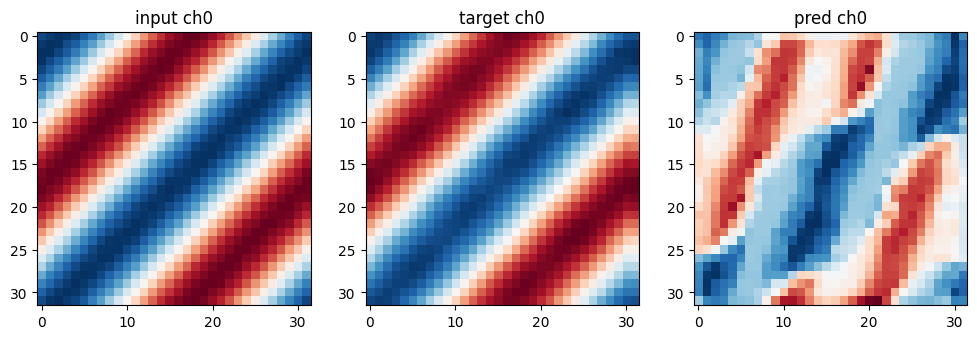

In [16]:
# Full Colab-ready script: AAO improved with top-k, learnable temperature, spectral norm, entropy penalty.


import os
import math
import time
import random
import numpy as np
import matplotlib.pyplot as plt
from tqdm.auto import tqdm

import torch
import torch.nn as nn
import torch.nn.functional as F
from torch.utils.data import Dataset, DataLoader
import torch.nn.utils as utils

# ---------------------------
# Repro & device
# ---------------------------
seed = 42
random.seed(seed)
np.random.seed(seed)
torch.manual_seed(seed)
if torch.cuda.is_available():
    torch.cuda.manual_seed_all(seed)
device = torch.device("cuda" if torch.cuda.is_available() else "cpu")
print("Device:", device)

# ---------------------------
# Synthetic ERA5-like generator
# ---------------------------
def generate_synthetic_era5(n_samples=1000, H=32, W=32, channels=4, noise=0.01):
    X = np.zeros((n_samples, channels, H, W), dtype=np.float32)
    Y = np.zeros_like(X)
    xs = np.linspace(0, 2*np.pi, W)
    ys = np.linspace(0, 2*np.pi, H)
    Xg, Yg = np.meshgrid(xs, ys)
    for i in range(n_samples):
        for c in range(channels):
            kx = np.random.randint(1, 4)
            ky = np.random.randint(1, 4)
            phase = np.random.rand() * 2*np.pi
            amp = 0.5 + np.random.rand()*0.8
            field = amp * np.sin(kx * Xg + ky * Yg + phase)
            shift_x = np.random.randint(-2, 3)
            shift_y = np.random.randint(-2, 3)
            field_t = np.roll(field, shift=(shift_y, shift_x), axis=(0,1))
            field_t += 0.05 * (np.cos(2*Xg + phase*c) * np.sin(3*Yg - phase*c))
            X[i, c] = field + noise * np.random.randn(H, W)
            Y[i, c] = field_t + noise * np.random.randn(H, W)
    return X, Y

# ---------------------------
# Dataset
# ---------------------------
class FieldDataset(Dataset):
    def __init__(self, X, Y):
        self.X = torch.from_numpy(X)
        self.Y = torch.from_numpy(Y)
    def __len__(self):
        return len(self.X)
    def __getitem__(self, idx):
        return self.X[idx], self.Y[idx]

# ---------------------------
# AAO block with top-k, learnable temperature, spectral norm option
# ---------------------------
class AAOBlock(nn.Module):
    def __init__(self, in_channels, hidden=64, t_init=1.0, learn_t=False, use_spectral_norm=False, topk=None):
        super().__init__()
        if learn_t:
            self.t = nn.Parameter(torch.tensor(float(t_init)))
        else:
            self.register_buffer('t', torch.tensor(float(t_init)))
        self.topk = topk  # None or integer
        self.to_q = nn.Conv2d(in_channels, hidden, kernel_size=1)
        self.to_k = nn.Conv2d(in_channels, hidden, kernel_size=1)
        self.to_v = nn.Conv2d(in_channels, hidden, kernel_size=1)
        self.proj = nn.Conv2d(hidden, in_channels, kernel_size=1)
        if use_spectral_norm:
            self.to_q = utils.spectral_norm(self.to_q)
            self.to_k = utils.spectral_norm(self.to_k)
            self.to_v = utils.spectral_norm(self.to_v)
            self.proj = utils.spectral_norm(self.proj)

    def forward(self, x):
        B, C, H, W = x.shape
        q = self.to_q(x); k = self.to_k(x); v = self.to_v(x)
        qf = q.view(B, q.shape[1], -1).permute(0,2,1)  # (B,N,d)
        kf = k.view(B, k.shape[1], -1).permute(0,2,1)
        vf = v.view(B, v.shape[1], -1).permute(0,2,1)
        d = qf.shape[-1]
        scores = torch.matmul(qf, kf.transpose(-2,-1)) / math.sqrt(d)  # (B,N,N)
        t = self.t if isinstance(self.t, torch.Tensor) else torch.tensor(self.t, device=scores.device)
        # Top-k masking (if requested)
        if self.topk is not None:
            k_ = int(self.topk)
            # per-row topk: replace others by -inf
            topk_vals, topk_idx = torch.topk(scores, k_, dim=-1)  # (B,N,k)
            mask = torch.full_like(scores, float("-inf"))
            mask.scatter_(-1, topk_idx, topk_vals)
            scores_masked = mask
            w = F.softmax(t * scores_masked, dim=-1)
        else:
            w = F.softmax(t * scores, dim=-1)
        out = torch.matmul(w, vf)
        out = out.permute(0,2,1).view(B, q.shape[1], H, W)
        out = self.proj(out)
        # instrumentation
        eps = 1e-12
        w_flat = w + eps
        H_shannon = -(w_flat * w_flat.log()).sum(dim=-1)         # (B, N)
        renyi2 = -torch.log((w_flat**2).sum(dim=-1) + eps)      # (B, N)
        sum_w2 = (w_flat**2).sum(dim=-1)                        # (B, N)
        traceA = 1.0 - sum_w2                                   # (B, N)
        A_op_bound = traceA                                     # proxy per row
        info = {'w': w, 'H': H_shannon, 'H2': renyi2, 'traceA': traceA, 'Aop': A_op_bound, 't': float(t)}
        return out, info

class AAOModel(nn.Module):
    def __init__(self, in_channels=4, t_init=1.0, learn_t=False, use_spectral_norm=False, topk=None):
        super().__init__()
        self.block = AAOBlock(in_channels, hidden=64, t_init=t_init, learn_t=learn_t, use_spectral_norm=use_spectral_norm, topk=topk)
        self.bn = nn.BatchNorm2d(in_channels)
        self.conv1 = nn.Conv2d(in_channels, in_channels, kernel_size=3, padding=1)
        if use_spectral_norm:
            self.conv1 = utils.spectral_norm(self.conv1)

    def forward(self, x):
        out, info = self.block(x)
        out = self.conv1(F.relu(self.bn(out)))
        return out, info

# ---------------------------
# Simple CNN baseline
# ---------------------------
class CNNBaseline(nn.Module):
    def __init__(self, in_channels=4):
        super().__init__()
        self.net = nn.Sequential(
            nn.Conv2d(in_channels, 64, 3, padding=1),
            nn.ReLU(),
            nn.Conv2d(64, 64, 3, padding=1),
            nn.ReLU(),
            nn.Conv2d(64, in_channels, 1)
        )
    def forward(self, x):
        return self.net(x)

# ---------------------------
# Utilities: metrics, empirical Lipschitz, spectral norm estimate
# ---------------------------
def rmse(pred, target):
    return torch.sqrt(F.mse_loss(pred, target))

def empirical_lipschitz(model, x, eps=1e-3, n_samples=6):
    model.eval()
    with torch.no_grad():
        out0 = model(x)
        if isinstance(out0, tuple):
            f0, _ = out0
        else:
            f0 = out0
        norms = []
        x_norm = x.reshape(x.shape[0], -1).norm(p=2, dim=-1).mean().item()
        for _ in range(n_samples):
            delta = torch.randn_like(x)
            delta = delta / (delta.reshape(delta.shape[0], -1).norm(p=2, dim=-1).reshape(-1,1,1,1) + 1e-12)
            delta = delta * (eps * max(x_norm, 1e-6))
            xp = x + delta
            outp = model(xp)
            if isinstance(outp, tuple):
                fp, _ = outp
            else:
                fp = outp
            num = (fp - f0).reshape(fp.shape[0], -1).norm(p=2, dim=-1)
            den = delta.reshape(delta.shape[0], -1).norm(p=2, dim=-1)
            ratio = (num/den).cpu().numpy()
            norms.append(ratio)
        arr = np.concatenate(norms, axis=0)
        return float(arr.mean()), float(arr.std())

def spectral_norm_estimate_conv(conv):
    with torch.no_grad():
        W = conv.weight.detach()  # (out, in, kH, kW)
        outc, inc, kH, kW = W.shape
        M = W.view(outc, -1)  # (outc, inc*kH*kW)
        try:
            s = torch.linalg.svdvals(M)[0].item()
        except Exception:
            v = torch.randn(M.shape[1], device=M.device)
            v = v / (v.norm() + 1e-12)
            for _ in range(20):
                u = M @ v
                u = u / (u.norm() + 1e-12)
                v = M.T @ u
                v = v / (v.norm() + 1e-12)
            s = (M @ v).norm().item()
        return s

def compute_adaptive_bound(info_batch, t_scalar, C_V_estimate=None):
    Aop = info_batch['Aop']           # (scalar mean)
    Aop_mean = float(Aop)
    if C_V_estimate is None:
        C_V_estimate = 1.0
    bound = abs(t_scalar) * C_V_estimate * Aop_mean
    return bound, Aop_mean

# ---------------------------
# Train & evaluation routines
# ---------------------------
def train_model(model, loader_train, loader_val, args):
    optimizer = torch.optim.Adam(model.parameters(), lr=args['lr'], weight_decay=args.get('weight_decay', 0.0))
    scheduler = torch.optim.lr_scheduler.StepLR(optimizer, step_size=args.get('step_size', 50), gamma=0.5)
    best_val = 1e9; best_path = None
    for epoch in range(1, args['n_epochs']+1):
        model.train()
        train_losses = []
        for xb, yb in loader_train:
            xb = xb.to(device); yb = yb.to(device)
            optimizer.zero_grad()
            out = model(xb)
            if isinstance(out, tuple):
                pred, info = out
            else:
                pred = out; info = {}
            mse = F.mse_loss(pred, yb)
            loss = mse
            if args.get('lambda_entropy', 0.0) > 0 and 'H' in info:
                ent_pen = info['H'].mean()
                loss = loss + args['lambda_entropy'] * ent_pen
            loss.backward()
            max_norm = args.get('grad_clip', 1.0)
            if max_norm is not None:
                torch.nn.utils.clip_grad_norm_(model.parameters(), max_norm)
            optimizer.step()
            train_losses.append(loss.item())
        scheduler.step()

        # validation & instrumentation aggregation
        model.eval()
        val_losses = []
        val_infos = []
        with torch.no_grad():
            for xb, yb in loader_val:
                xb = xb.to(device); yb = yb.to(device)
                out = model(xb)
                if isinstance(out, tuple):
                    pred, info = out
                else:
                    pred = out; info = {}
                val_losses.append(F.mse_loss(pred, yb).item())
                if info:
                    # reduce each info to scalar averages for aggregation
                    scalar_info = {}
                    for k in ['H','H2','traceA','Aop','t']:
                        if k in info:
                            if k == 't':
                                scalar_info[k] = float(info[k])
                            else:
                                scalar_info[k] = float(info[k].mean().item())
                    val_infos.append(scalar_info)
        val_loss = float(np.mean(val_losses))

        # aggregate instrumentation over val batches
        aggregated = {}
        if len(val_infos) > 0:
            keys = set().union(*[set(d.keys()) for d in val_infos])
            for k in keys:
                vals = [d[k] for d in val_infos if k in d]
                aggregated[k] = float(np.mean(vals))

        # estimate C_V (proxy) if applicable
        C_V_est = None
        if hasattr(model, 'block') and hasattr(model.block, 'proj'):
            try:
                C_V_est = spectral_norm_estimate_conv(model.block.proj)
            except Exception:
                C_V_est = None

        # compute adaptive bound (approx)
        if 'Aop' in aggregated:
            t_scalar = aggregated.get('t', getattr(getattr(model,'block',None),'t',1.0))
            if isinstance(t_scalar, torch.Tensor):
                t_scalar = float(t_scalar)
            bound, meanA = compute_adaptive_bound({'Aop': aggregated['Aop']}, t_scalar, C_V_estimate=(C_V_est or 1.0))
        else:
            bound, meanA = None, None

        print(f"Epoch {epoch} | train_loss {np.mean(train_losses):.6f} | val_loss {val_loss:.6f} | entropy_mean {aggregated.get('H', None)} | trace_mean {aggregated.get('traceA', None)} | bound(est) {bound} | C_V_est {C_V_est} | t {aggregated.get('t', None)}")

        # save best
        if val_loss < best_val:
            os.makedirs("checkpoints", exist_ok=True)
            path = f"checkpoints/{args['name']}_best.pt"
            torch.save({'model_state_dict': model.state_dict()}, path)
            best_val = val_loss
            best_path = path

    return best_path

def evaluate_model(model, loader_test):
    model.eval()
    rmses = []
    entropies = []
    traces = []
    renyi2s = []
    lips = []
    with torch.no_grad():
        for xb, yb in loader_test:
            xb = xb.to(device); yb = yb.to(device)
            out = model(xb)
            if isinstance(out, tuple):
                pred, info = out
            else:
                pred = out; info = {}
            rmses.append(rmse(pred, yb).item())
            if 'H' in info:
                entropies.append(info['H'].mean().item())
            if 'traceA' in info:
                traces.append(info['traceA'].mean().item())
            if 'H2' in info:
                renyi2s.append(info['H2'].mean().item())
            l_emp, l_std = empirical_lipschitz(model, xb, eps=1e-3, n_samples=4)
            lips.append(l_emp)
    return {
        'rmse_mean': float(np.mean(rmses)),
        'entropy_mean': float(np.mean(entropies)) if entropies else None,
        'trace_mean': float(np.mean(traces)) if traces else None,
        'h2_mean': float(np.mean(renyi2s)) if renyi2s else None,
        'l_emp_mean': float(np.mean(lips)) if lips else None
    }

# ---------------------------
# Quick sweep util (temperature x topk x lambda)
# ---------------------------
def quick_sweep(train_loader, val_loader, test_loader, channels, H, W, t_list=[1.0,2.0,5.0], topk_list=[None,128,32], lambda_list=[0.0,1e-3]):
    results = []
    for t_init in t_list:
        for topk in topk_list:
            for lam in lambda_list:
                print("RUN:", "t=", t_init, "| topk=", topk, "| lambda=", lam)
                model = AAOModel(in_channels=channels, t_init=t_init, learn_t=False, use_spectral_norm=True, topk=topk).to(device)
                args = {'n_epochs':4, 'lr':5e-4, 'lambda_entropy': lam, 'name': f"tmp_t{t_init}_k{topk}_l{lam}", 'step_size': 2, 'grad_clip':1.0, 'weight_decay':1e-4}
                _ = train_model(model, train_loader, val_loader, args)
                res = evaluate_model(model, test_loader)
                print("Result:", res)
                results.append({'t':t_init,'topk':topk,'lambda':lam,'res':res})
    return results

# ---------------------------
# Main experiment: run once (or call quick_sweep)
# ---------------------------
def main():
    # params
    H = W = 32
    channels = 4
    n_train = 800
    n_val = 100
    n_test = 100
    batch_size = 16

    # generate data
    X_all, Y_all = generate_synthetic_era5(n_train + n_val + n_test, H=H, W=W, channels=channels)
    X_train, Y_train = X_all[:n_train], Y_all[:n_train]
    X_val, Y_val = X_all[n_train:n_train+n_val], Y_all[n_train:n_train+n_val]
    X_test, Y_test = X_all[-n_test:], Y_all[-n_test:]

    train_loader = DataLoader(FieldDataset(X_train, Y_train), batch_size=batch_size, shuffle=True)
    val_loader = DataLoader(FieldDataset(X_val, Y_val), batch_size=batch_size)
    test_loader = DataLoader(FieldDataset(X_test, Y_test), batch_size=batch_size)

    # single run config (you can change these)
    use_spectral_norm = True
    learn_t = False
    t_init = 5.0            # try 1.0, 2.0, 5.0, 10.0
    topk = 64               # try None or a small integer like 128/64/32
    lambda_entropy = 1e-3   # try 0.0, 1e-3, 5e-3, 1e-2

    aao = AAOModel(in_channels=channels, t_init=t_init, learn_t=learn_t, use_spectral_norm=use_spectral_norm, topk=topk).to(device)
    cnn = CNNBaseline(in_channels=channels).to(device)

    print("Training AAO (config):", {'t_init': t_init, 'learn_t': learn_t, 'use_spectral_norm': use_spectral_norm, 'topk': topk, 'lambda_entropy': lambda_entropy})
    args = {'n_epochs':8, 'lr':5e-4, 'lambda_entropy': lambda_entropy, 'name': f"aao_t{t_init}_k{topk}", 'step_size': 4, 'grad_clip':1.0, 'weight_decay':1e-4}
    best_aao = train_model(aao, train_loader, val_loader, args)

    print("Training CNN baseline")
    args_cnn = {'n_epochs':8, 'lr':5e-4, 'lambda_entropy': 0.0, 'name': "cnn_baseline", 'step_size': 4, 'grad_clip':1.0, 'weight_decay':1e-4}
    best_cnn = train_model(cnn, train_loader, val_loader, args_cnn)

    print("Evaluating AAO")
    res_aao = evaluate_model(aao, test_loader)
    print(res_aao)
    print("Evaluating CNN")
    res_cnn = evaluate_model(cnn, test_loader)
    print(res_cnn)

    # diagnostics
    N = H * W
    print("Context N:", N, "ln(N):", math.log(N))
    print("AAO entropy mean:", res_aao['entropy_mean'])
    print("AAO trace mean:", res_aao['trace_mean'])
    print("AAO empirical Lipschitz:", res_aao['l_emp_mean'])
    print("CNN empirical Lipschitz:", res_cnn['l_emp_mean'])

    # sample visualization
    xb = torch.from_numpy(X_test[:1]).to(device)
    aao.eval()
    with torch.no_grad():
        pred, info = aao(xb)
        pred = pred.cpu().numpy()[0]
        inp = xb.cpu().numpy()[0]
    fig, axes = plt.subplots(1,3, figsize=(12,4))
    axes[0].imshow(inp[0], cmap='RdBu'); axes[0].set_title("input ch0")
    axes[1].imshow(Y_test[0][0], cmap='RdBu'); axes[1].set_title("target ch0")
    axes[2].imshow(pred[0], cmap='RdBu'); axes[2].set_title("pred ch0")
    plt.show()

    # OPTIONAL: quick sweep (uncomment to run small grid)
    # sweep_results = quick_sweep(train_loader, val_loader, test_loader, channels, H, W,
    #                             t_list=[1.0,2.0,5.0], topk_list=[None,128,64], lambda_list=[0.0,1e-3])

if __name__ == "__main__":
    main()